Here is a notebook that compares two YOLO models. The models were trained using the SuperGradients and Ultralytics libraries for 35 epochs. The medium size was used for Ultralytics and YOLO-NAS. The metrics compared were as follows:

From the SuperGradients library:
- Precision 0.50: 0.0429,
- Recall 0.50: 0.9770,
- mAP 0.50: 0.7441,
- F1 0.50: 0.0822

From the Ultralytics library:
- Precision(B): 0.7733
- Recall(B): 0.8276
- mAP50(B): 0.8473
- mAP50-95(B): 0.6056
- Fitness: 0.6298



In addtion the original images and predictions are plotted below to give a visual aid of the predictions. 

After looking at the results it appears the ultralytics library performed better
however further testing needs to be done. 

Useful links

Supervision: https://github.com/roboflow/supervision/tree/main

YOLONAS: https://www.kaggle.com/discussions/general/409402

YOLOv8: https://github.com/ultralytics/ultralytics


In [1]:
#Install YOLO-NAS
!pip install super-gradients==3.1.1 --quiet
!pip install --upgrade pillow --quiet
!pip install --upgrade torchvision --quiet
#dataset and vis utils
!pip install -q supervision
#yolo ultralytics
!pip install ultralytics --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.4.1 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cuml 23.4.1 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
dask-cudf 23.4.1 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
aiobotocore 2.5.0 requires botocore<1.29.77,>=1.29.76, but you have botocore 1.29.153 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 10.0.1 which is incompatible.
cudf 23.4.1 requires protobuf<4.22,>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
cuml 23.4.1 requires dask==2023.3.2, but you have dask 2023.5.0 which is incompatible.
dask-cuda 23.4.0 requires dask==2023.3.2, but you have dask 2023.5.0 which is incompatible.
dask-cu

In [2]:
#setting HOME as a constant
import os
#data trained on
DATA = "/kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir"
# save_folder = os.path.join(LOCATION, 'YoloNas')
#where our checkpoints/model is saved
CHECKPOINT_DIR = '/kaggle/input/pinotnoirgrapes/YOLO-NASm'

DIRS = {
    'DATA': DATA,
    'CHECKPOINT': CHECKPOINT_DIR,
    'TEST': os.path.join(DATA, 'test')
}
PATHS= {
    'YOLO_NAS':os.path.join(DIRS['CHECKPOINT'], 'average_model.pth'),
    'YOLO_ULTRA':"/kaggle/input/pinotnoirgrapes/Grapes/Grapes/models/yolov8/single_box_grape/weights/best.pt",
    'YAML': "/kaggle/input/pinotnoirgrapes/data.yaml"
}


In [3]:
#setting our device
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"


In [4]:
from super_gradients.training import Trainer
EXPERIMENT_NAME = 'GrapeDetector'
trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=DIRS['CHECKPOINT'])

[2023-06-14 00:17:00] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
CLASSES=['grape']
dataset_params = {
    'data_dir': DIRS['DATA'],
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}

In [6]:
#defining nas model
from super_gradients.training.dataloaders.dataloaders import  coco_detection_yolo_format_val

BATCH_SIZE=8

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

Caching annotations: 100%|██████████| 10/10 [00:00<00:00, 49.96it/s]


In [7]:
#defining nas model
from super_gradients.training import models
nas_model_arch = 'yolo_nas_m'
nas_model = models.get(nas_model_arch,
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path=PATHS['YOLO_NAS'])

[2023-06-14 00:17:27] INFO - checkpoint_utils.py - Successfully loaded model weights from /kaggle/input/pinotnoirgrapes/YOLO-NASm/average_model.pth EMA checkpoint.


In [8]:
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback


call_back=post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                nms_top_k=1000, 
                                                                max_predictions=300,                                                                              
                                                                nms_threshold=0.7)
nas_results=trainer.test(model=nas_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=call_back))

Test: 100%|██████████| 2/2 [00:08<00:00,  3.72s/it]

In [9]:
#view nas results
nas_results


{'Precision@0.50': tensor(0.0429),
 'Recall@0.50': tensor(0.9770),
 'mAP@0.50': tensor(0.7441),
 'F1@0.50': tensor(0.0822)}

In [10]:
#defining ultralytics model
from ultralytics import YOLO
yolo_ultra = YOLO(PATHS['YOLO_ULTRA'])


Test: 100%|██████████| 2/2 [00:09<00:00,  4.53s/it]


In [11]:
#docs. https://docs.ultralytics.com/modes/val/
#set split to test to eval on test set
ultra_results=yolo_ultra.val(split='test', data=PATHS['YAML'])


Ultralytics YOLOv8.0.117 🚀 Python-3.10.10 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients
100%|██████████| 755k/755k [00:00<00:00, 17.1MB/s]
val: Scanning /kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir/test/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 308.65it/s]
val: WARNING ⚠️ Cache directory /kaggle/input/pinotnoirgrapes/Grapes/Grapes/PinotNoir/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                   all         10         87      0.773      0.828      0.847      0.606


In [12]:
ultra_results.results_dict

{'metrics/precision(B)': 0.7733052650873103,
 'metrics/recall(B)': 0.8275862068965517,
 'metrics/mAP50(B)': 0.8473158752057782,
 'metrics/mAP50-95(B)': 0.6056238155422475,
 'fitness': 0.6297930215086006}

**Visualize from test data**

In [13]:
#preparing the data for visualization 
import supervision as sv

def get_predictions_from_dataset(dataset,  model, mode=None, conf=0.5,iou=.2, image_folder=None):
  """
  make predictions on a data set with a model trained with the supergradients lib
  or the ultralytics lib. the format of the results differ slightly so we need
  two seperate ways to get predictions.

  dataset: class from supervision where we can easily load our data in
  model: our working model trained with NAS or ultralytics
  mode: nas or ultra. set to the model lib
  conf: confidence threshold
  iou: iou thresh
  image_folder:
  """
  modes=['nas', 'ultra']
  assert mode in modes, 'Must pass nas or ultra in mode arg'

  if mode=='nas':
    predictions = get_predictions_from_nas(dataset=dataset,
                                           model=model, 
                                           conf=conf, 
                                           iou=iou)
    return predictions

  if mode=='ultra':
    predictions = get_predictions_from_ultra(dataset=dataset,
                                             model=model, 
                                             conf=conf, 
                                             iou=iou
                                            )
    return predictions

  return 'no predictions found'

def get_predictions_from_nas(dataset, model, conf, iou):
  predictions = {}

  for image_name, image in dataset.images.items():
    result = list(model.predict(image, conf=conf, iou=iou))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections
  return predictions

def get_predictions_from_ultra(dataset, model, conf, iou):
    predictions = {}

    for image_name, image in dataset.images.items():
      result = list(model.predict(source=image, conf=conf, iou=iou))[0]
      detections = sv.Detections(
          xyxy=result.boxes.xyxy.cpu().numpy(),
          confidence=result.boxes.conf.cpu().numpy(),
          class_id=result.boxes.cls.cpu().numpy().astype(int)
      )
      predictions[image_name] = detections
    return predictions

In [14]:
#vis utils

def prepare_images_pred_frames(keys, dataset, predictions, id_to_label, box_annotator):
  """
  getting our image and prediction frames to use in plot images grid
  """
  images = []
  titles = []
  for key in keys:
      current_ann=ds.annotations[key]
      gt_labels = [id_to_label[id] for id in current_ann.class_id]
      
      frame_with_annotations = box_annotator.annotate(
          scene=ds.images[key].copy(),
          detections=current_ann,
          labels=gt_labels
      )
      images.append(frame_with_annotations)
      titles.append('annotations')
      current_pred = predictions[key]
      pred_labels=[id_to_label[id] for id in current_pred.class_id]
      frame_with_predictions = box_annotator.annotate(
          scene=ds.images[key].copy(),
          detections= current_pred,
          labels=pred_labels
      )
      images.append(frame_with_predictions)
      titles.append('predictions')
  return images, titles 


In [15]:
import supervision as sv
#creating our dataset
#doesn't load JPG
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=os.path.join(DIRS['TEST'], 'images'),
    annotations_directory_path=os.path.join(DIRS['TEST'], 'labels'),
    data_yaml_path=PATHS['YAML'],
    force_masks=False
)
print(len(ds))

Speed: 0.3ms preprocess, 31.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val


In [16]:
ultra_preds=get_predictions_from_dataset(dataset=ds, model=yolo_ultra, mode='ultra')


10



0: 480x640 8 grapes, 79.8ms
Speed: 3.8ms preprocess, 79.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 5 grapes, 80.4ms
Speed: 3.1ms preprocess, 80.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 9 grapes, 29.1ms
Speed: 3.9ms preprocess, 29.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 grapes, 38.3ms
Speed: 4.6ms preprocess, 38.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 grapes, 31.1ms
Speed: 2.5ms preprocess, 31.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 grapes, 29.4ms
Speed: 2.4ms preprocess, 29.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 grapes, 29.4ms
Speed: 2.4ms preprocess, 29.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



In [17]:
nas_preds=get_predictions_from_dataset(dataset=ds, model=nas_model, mode='nas')

0: 640x640 6 grapes, 29.4ms
Speed: 2.3ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 6 grapes, 80.8ms
Speed: 2.7ms preprocess, 80.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 grapes, 20.2ms
Speed: 3.8ms preprocess, 20.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


In [18]:
#vis params
import random
random.seed(10)

MAX_IMAGE_COUNT = 5
n = min(MAX_IMAGE_COUNT, len(ds.images))
keys = list(ds.images.keys())
keys = random.sample(keys, n)
id_to_label = {0:'grape'}


Plotting nas preds...


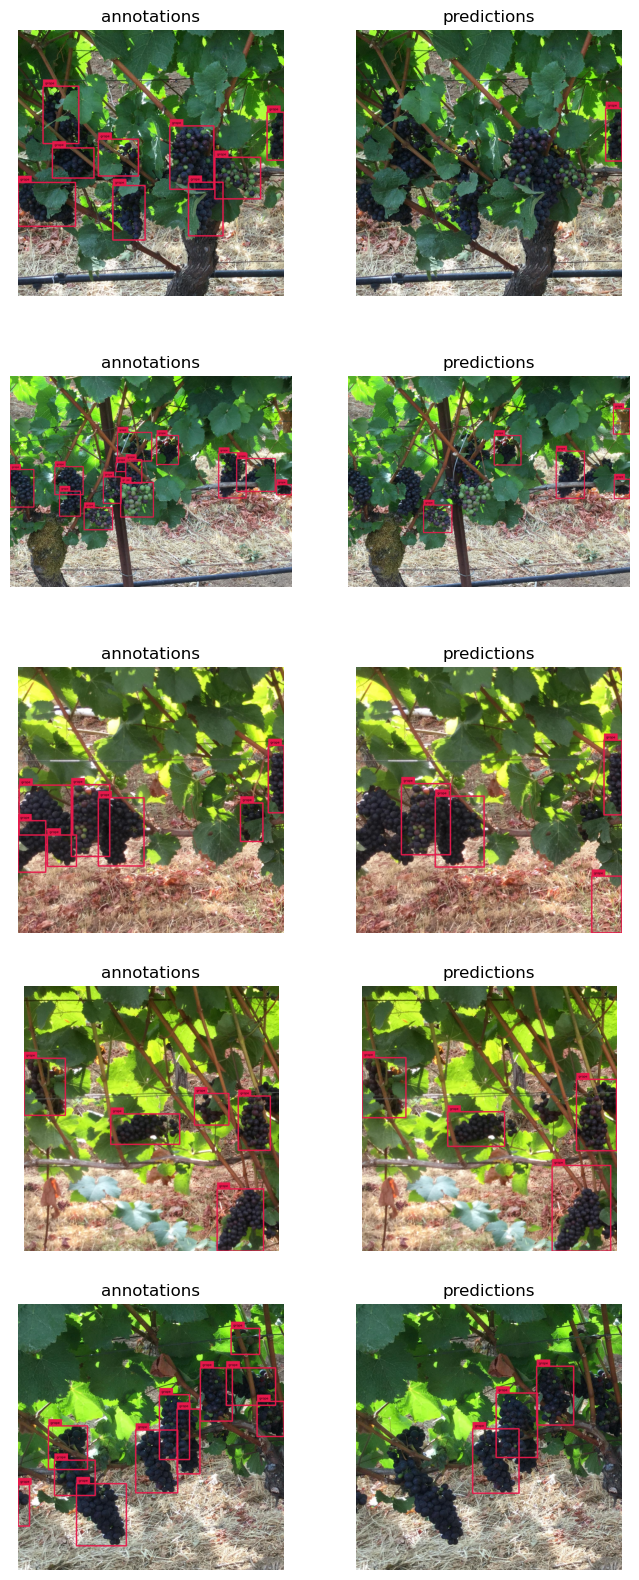

In [19]:
#plotting nas preds 
import supervision as sv
print('Plotting nas preds...')
box_annotator = sv.BoxAnnotator(thickness=5)
images, titles = prepare_images_pred_frames(keys=keys, dataset=ds, predictions=nas_preds, id_to_label=id_to_label, box_annotator=box_annotator)
%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))

Plotting ultra preds...


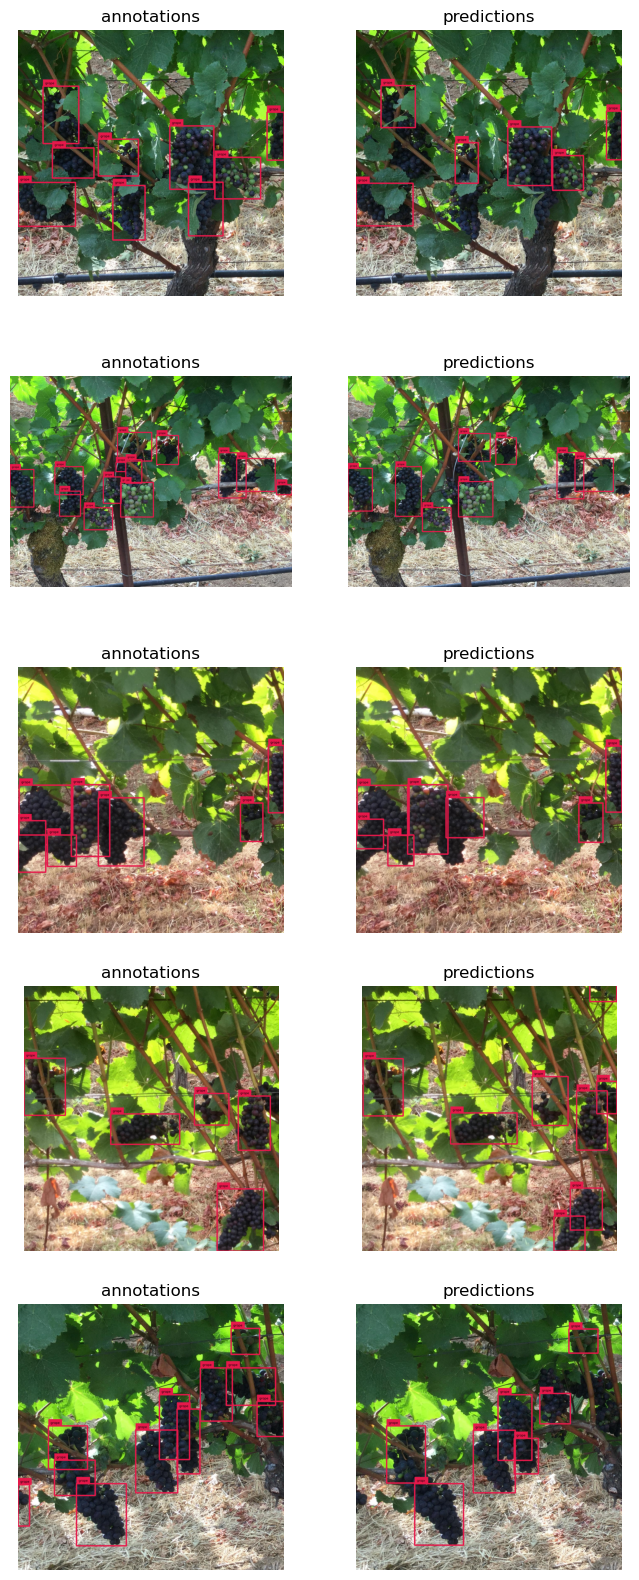

In [20]:
#plotting ultra preds 
import supervision as sv
print('Plotting ultra preds...')
box_annotator = sv.BoxAnnotator(thickness=5)
images, titles = prepare_images_pred_frames(keys=keys, dataset=ds, predictions=ultra_preds, id_to_label=id_to_label, box_annotator=box_annotator)
%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))